In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### **Section 1: Setup**

In [2]:
import os
from kaggle_secrets import UserSecretsClient

try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    print("✅ Gemini API key setup complete.")
except Exception as e:
    print(
        f"🔑 Authentication Error: Please make sure you have added 'GOOGLE_API_KEY' to your Kaggle secrets. Details: {e}"
    )

✅ Gemini API key setup complete.


In [3]:
from google.adk.agents import Agent, SequentialAgent, ParallelAgent, LoopAgent
from google.adk.models.google_llm import Gemini
from google.adk.runners import InMemoryRunner
from google.adk.tools import AgentTool, FunctionTool, google_search
from google.genai import types

print("ADK component imported!!!")

ADK component imported!!!


In [4]:
retry_config=types.HttpRetryOptions(
    attempts=5,
    exp_base=7,
    initial_delay=1,
    http_status_codes=[429,500,503,504]
)

## **creation multi agent sys**


## **Loop Workflows - The Refinement Cycle**

- When a task needs to be improved through cycles of feedback and revision, you can use a LoopAgent.
-  A LoopAgent runs a set of sub-agents repeatedly until a specific condition is met or a maximum number of iterations is reached. This creates a refinement cycle, allowing the agent system to improve its own work over and over.

- Use Loop when: Iterative improvement is needed, quality refinement matters, or you need repeated cycles.
- Architecture: Story Writing & Critique Loop

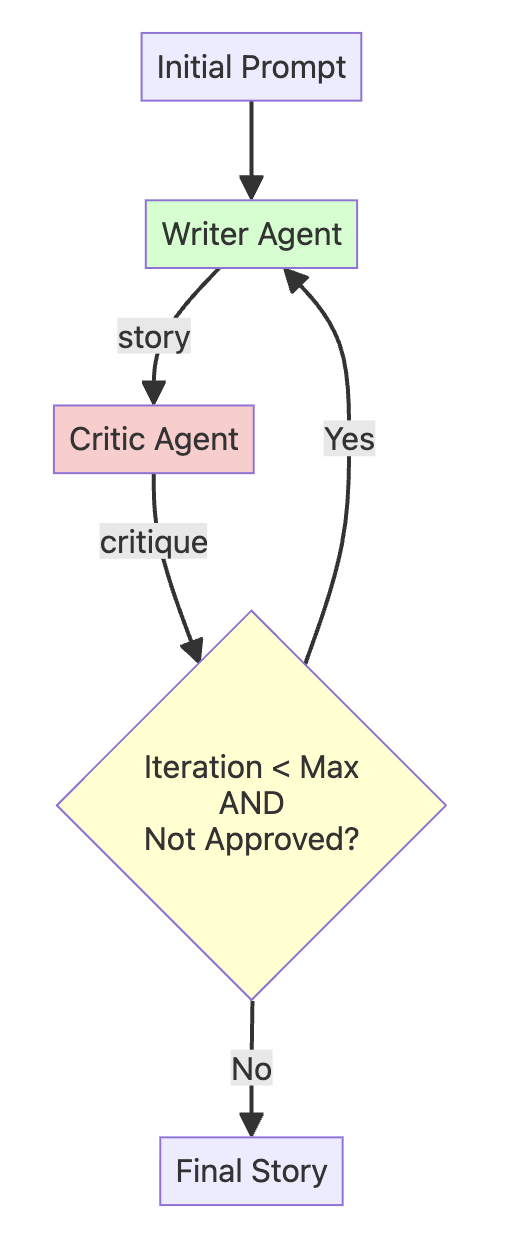
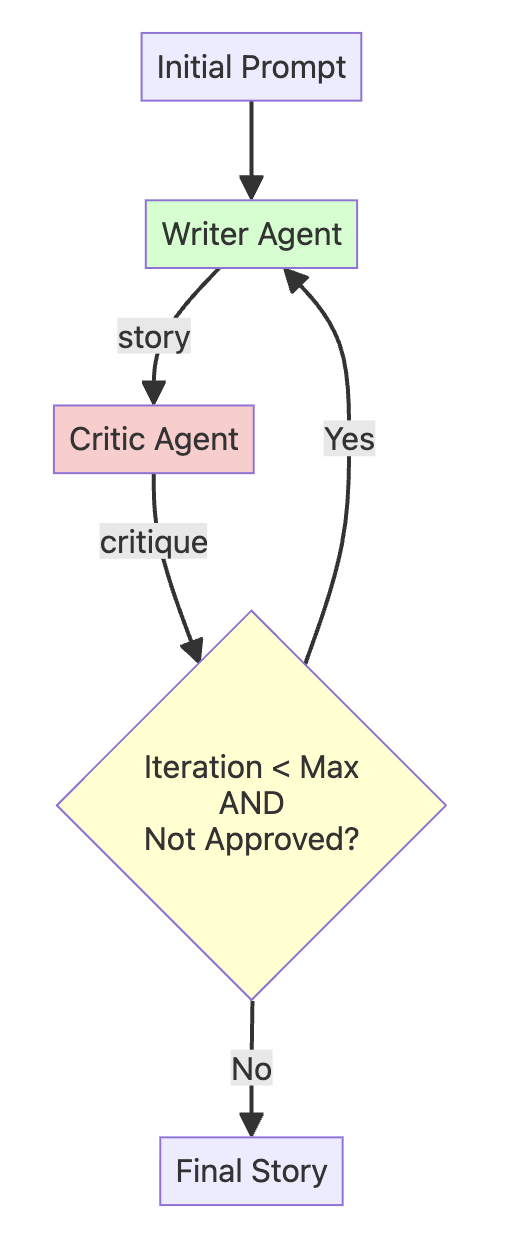

####  Iterative Story Refinement¶
Let's build a system with two agents:

- Writer Agent - Writes a draft of a short story
- Critic Agent - Reviews and critiques the short story to suggest improvements.

In [14]:
# This agent runs ONCE at the beginning to create the first draft.
initial_writer_agent = Agent(
    name="InitialWriterAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""Based on the user's prompt, write the first draft of a short story (around 100-150 words).
    Output only the story text, with no introduction or explanation.""",
    output_key="current_story", 
)
print("initial_writer_agent created.")

initial_writer_agent created.


In [15]:
# This agent's only job is to provide feedback or the approval signal. It has no tools.
critic_agent = Agent(
    name="CriticAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a constructive story critic. Review the story provided below.
    Story: {current_story}
    
    Evaluate the story's plot, characters, and pacing.
    - If the story is well-written and complete, you MUST respond with the exact phrase: "APPROVED"
    - Otherwise, provide 2-3 specific, actionable suggestions for improvement.""",
    output_key="critique", 
)

print("critic_agent created.")

critic_agent created.


Now, we need a way for the loop to actually stop based on the critic's feedback. The LoopAgent itself doesn't automatically know that "APPROVED" means "stop."

We need an agent to give it an explicit signal to terminate the loop.

We do this in two parts:

- A simple Python function that the LoopAgent understands as an "exit" signal.
- An agent that can call that function when the right condition is met.

In [19]:
# This is the function that the RefinerAgent will call to exit the loop.
# Note: Statement written in """...""" at the begain of fuunction is docString used to explains what the function does.
def exit_loop():
    """Call this function ONLY when the critique is 'APPROVED', indicating the story is finished and no more changes are needed."""
    return {"status": "approved", "message": "Story approved. Exiting refinement loop."}

print("exit_loop function created.")

exit_loop function created.


RefinerAgent is the "brain" of the loop. It reads the {critique} from the CriticAgent and decides whether to 

(1) call the exit_loop tool or 

(2) rewrite the story.

In [20]:
# This agent refines the story based on critique OR calls the exit_loop function.
refiner_agent = Agent(
    name="RefinerAgent",
    model=Gemini(
        model="gemini-2.5-flash-lite",
        retry_options=retry_config
    ),
    instruction="""You are a story refiner. You have a story draft and critique.
    
    Story Draft: {current_story}
    Critique: {critique}
    
    Your task is to analyze the critique.
    - IF the critique is EXACTLY "APPROVED", you MUST call the `exit_loop` function and nothing else.
    - OTHERWISE, rewrite the story draft to fully incorporate the feedback from the critique.""",
    output_key="current_story",  # It overwrites the story with the new, refined version.
    tools=[
        FunctionTool(exit_loop)
    ],  # The tool is now correctly initialized with the function reference.
)

print(" refiner_agent created.")

 refiner_agent created.


In [21]:
# The LoopAgent contains the agents that will run repeatedly: Critic -> Refiner.
story_refinement_loop = LoopAgent(
    name="StoryRefinementLoop",
    sub_agents=[critic_agent, refiner_agent],
    max_iterations=2,  # Prevents infinite loops
)

# The root agent is a SequentialAgent that defines the overall workflow: Initial Write -> Refinement Loop.
root_agent = SequentialAgent(
    name="StoryPipeline",
    sub_agents=[initial_writer_agent, story_refinement_loop],
)

print(" Loop and Sequential Agents created.")

 Loop and Sequential Agents created.


In [22]:
runner = InMemoryRunner(agent=root_agent)
response = await runner.run_debug(
    "Write a short story about a lighthouse keeper who discovers a mysterious, glowing map"
)


 ### Created new session: debug_session_id

User > Write a short story about a lighthouse keeper who discovers a mysterious, glowing map
InitialWriterAgent > Elias polished the Fresnel lens, the rhythmic sweep of light a familiar comfort against the encroaching dusk. For thirty years, the beam had been his only constant companion on this lonely spit of rock. Tonight, however, the sea offered a different kind of luminescence. A small, wooden box bobbed near the shore, nudged by the tide. Inside, nestled on a bed of dried seaweed, was a rolled parchment.

Unfurling it, Elias gasped. The map wasn't of any coastline he recognized. Strange, swirling symbols marked its surface, and a faint, ethereal blue light pulsed from its inked lines. It depicted islands that defied geography, a constellation of shimmering dots leading to a central, radiant X. The air around him seemed to hum with an ancient energy. The lighthouse, his steadfast sentinel, suddenly felt like a mere prelude to a much gran

**a loop agent, creating a sophisticated system that can iteratively review and improve its own output. This is a key pattern for ensuring high-quality results.**